# Классификатор тонов китайского языка с использованием RNN

Архитектура модели рекурентной нейронной сети, используемой для создания классификатора тонов в многосложных китайских словах на диалекте путунхуа.

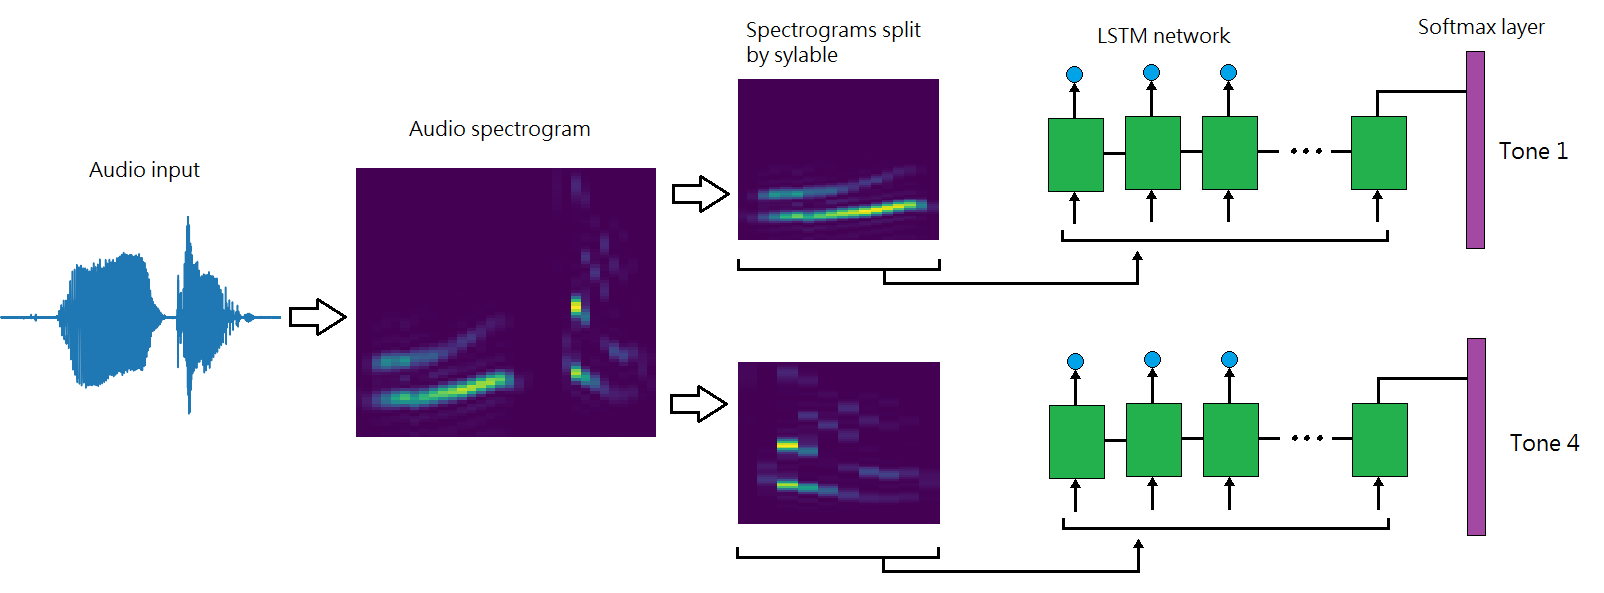

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import random

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline

!pip install pydub

import requests
from io import BytesIO
from pydub import AudioSegment
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

#добавила, когда начала появляться ошибка
!pip install ffmpeg
#!apt-get install ffmpeg

import matplotlib.gridspec as gridspec

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
#импортируем датасет из HF
df = pd.read_csv("hf://datasets/MariyaMegre/hsk-dataset/hsk4_dataset.csv")
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,Unnamed: 0,Audio File,Word,Pinyin,Meaning,tones
0,0,https://raw.githubusercontent.com/ManiyaRaskol...,爱情,àiqíng,love (romantic),4-2
1,1,https://raw.githubusercontent.com/ManiyaRaskol...,标准,biāozhǔn,standard,1-3
2,2,https://raw.githubusercontent.com/ManiyaRaskol...,饼干,bǐnggān,biscuit,3-1
3,3,https://raw.githubusercontent.com/ManiyaRaskol...,材料,cáiliào,"data, material",2-4
4,4,https://raw.githubusercontent.com/ManiyaRaskol...,窗户,chuānghù,window,1-4


In [ ]:
# сделаем столбец  Unnamed: 0 индексами
df = df.rename(columns={'Unnamed: 0': 'id'}).set_index('id')
df.head()

,Audio File,Word,Pinyin,Meaning,tones
id,,,,,
0,https://raw.githubusercontent.com/ManiyaRaskol...,爱情,àiqíng,love (romantic),4-2
1,https://raw.githubusercontent.com/ManiyaRaskol...,标准,biāozhǔn,standard,1-3
2,https://raw.githubusercontent.com/ManiyaRaskol...,饼干,bǐnggān,biscuit,3-1
3,https://raw.githubusercontent.com/ManiyaRaskol...,材料,cáiliào,"data, material",2-4
4,https://raw.githubusercontent.com/ManiyaRaskol...,窗户,chuānghù,window,1-4


В китайском языке существуют правила чтения, согласно которым 3 тон в зависимости от позиции в слове, читается как 2. Поэтому изменим метки тона согласно этим правиалам.

In [ ]:
# если 3 тон идет подряд 2 раза, первый слог читается в 2 тоне (3-3 –> 2-3)
df['tones'] = df['tones'].replace({'3-3': '2-3'})

# Обработка аудио и построение спектрограмм

In [ ]:
#импортируем библиотеку для получения спектрограммы аудиосигнала

from scipy import signal
from scipy.io import wavfile
import io

In [ ]:
#строим спектрограмму
url = df['Audio File'].iloc[0]
response = requests.get(url)
audio = AudioSegment.from_mp3(BytesIO(response.content))
samples = np.array(audio.get_array_of_samples())
fs = audio.frame_rate

f, t, Sxx = signal.spectrogram(samples, fs, nperseg=1024, nfft=1024*4)
f, t, Sxx # Добавляем столбец (frequency, time, amplitude)

(array([0.00000000e+00, 1.07666016e+01, 2.15332031e+01, ...,
        2.20284668e+04, 2.20392334e+04, 2.20500000e+04]),
 array([0.01160998, 0.03192744, 0.0522449 , 0.07256236, 0.09287982,
        0.11319728, 0.13351474, 0.1538322 , 0.17414966, 0.19446712,
        0.21478458, 0.23510204, 0.2554195 , 0.27573696, 0.29605442,
        0.31637188, 0.33668934, 0.3570068 , 0.37732426, 0.39764172,
        0.41795918, 0.43827664, 0.4585941 , 0.47891156, 0.49922902,
        0.51954649, 0.53986395, 0.56018141, 0.58049887, 0.60081633,
        0.62113379, 0.64145125, 0.66176871, 0.68208617, 0.70240363,
        0.72272109, 0.74303855, 0.76335601, 0.78367347, 0.80399093,
        0.82430839, 0.84462585, 0.86494331, 0.88526077, 0.90557823,
        0.92589569, 0.94621315, 0.96653061, 0.98684807, 1.00716553,
        1.02748299, 1.04780045, 1.06811791, 1.08843537, 1.10875283,
        1.12907029, 1.14938776, 1.16970522, 1.19002268, 1.21034014,
        1.2306576 , 1.25097506, 1.27129252, 1.29160998, 1.3119274

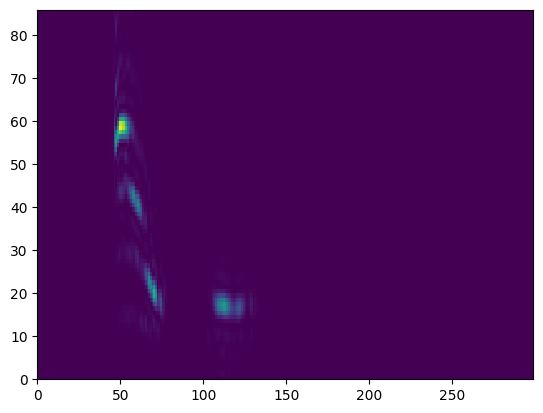

In [ ]:
#строим спектрограмму

url = df['Audio File'].iloc[0]
response = requests.get(url)
audio = AudioSegment.from_mp3(BytesIO(response.content))
samples = np.array(audio.get_array_of_samples())
fs = audio.frame_rate
f, t, Sxx = signal.spectrogram(samples, fs, nperseg=1024, nfft=1024*4)
Sxx = Sxx[:86]
plt.pcolormesh(Sxx)
plt.show()

In [ ]:
#функция для построения спектрограммы

def get_spectrogram(url):
  response = requests.get(url)
  audio = AudioSegment.from_mp3(BytesIO(response.content))
  samples = np.array(audio.get_array_of_samples())
  fs = audio.frame_rate

  f, t, Sxx = signal.spectrogram(samples, fs, nperseg=1024, nfft=1024*4)
  Sxx = Sxx[:86]
  return Sxx



In [ ]:
#функция для обрезания пауз в начале и конце аудиофайла

def trim_silences(Sxx):
  non_silent = list(np.max(Sxx, axis=0) > np.max(Sxx) * 0.01)
  start_id = non_silent.index(True)
  stop_id = len(non_silent) - 1 - non_silent[::-1].index(True)

  return Sxx[:, start_id:stop_id]


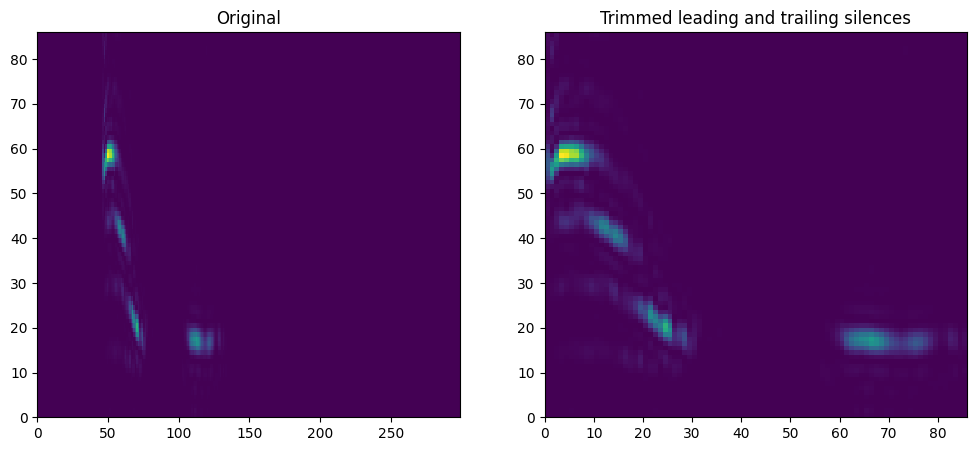

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].pcolormesh(Sxx)
ax[0].set_title("Original")
ax[1].pcolormesh(trim_silences(Sxx))
ax[1].set_title("Trimmed leading and trailing silences")
plt.show()

На данном этапе были удалены паузы в начале и конце аудиофайла, так как они не вносят никакой дополнительной информации для распознания тонов. Тишина при этом определяется как максимальная амплитуда менее 1% от максимальной амплитуды общей спектрограммы. Выше можно выидеть пример оригинальной и обрезанной спектрограммы для двухсложного слова 爱情 'любовь' c	тонами 4-2.

**Решение проблемы multi-label**

Один из способов обработки двух- и более слодных слов – разделение аудиофайла на отдельные слоги. Для этого напишем функцию, которая выполнит поиск в центральных двух четвертях временной области времени с наименьшей максимальной амплитудой и тем самым определит границу слога. Функция будет возращать список формата: спектрограмма для первого слога, для второго и т.д.

In [ ]:
def split_spectrogram(Sxx):

    q1 = Sxx.shape[1]//4
    q3 = 3*q1
    center = np.argmin(Sxx[:, q1:q3].max(axis=0))
    return trim_silences(Sxx[:, :q1+center]), trim_silences(Sxx[:, q1+center:])

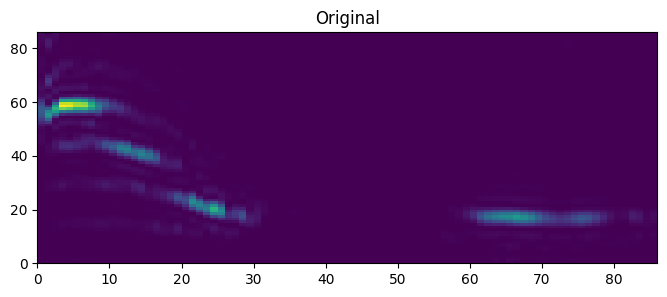

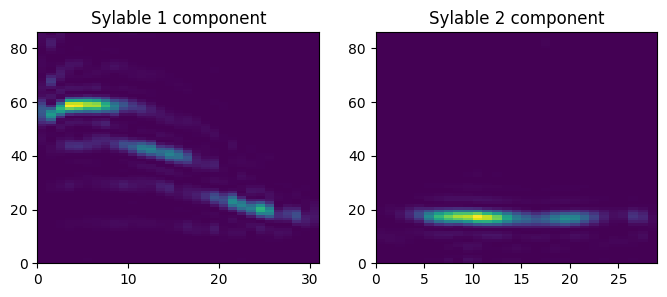

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.pcolormesh(trim_silences(Sxx))
ax.set_title("Original")
plt.show()

Sxx1, Sxx2 = split_spectrogram(trim_silences(Sxx))

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].pcolormesh(Sxx1)
ax[0].set_title("Sylable 1 component")
ax[1].pcolormesh(Sxx2)
ax[1].set_title("Sylable 2 component")
plt.show()


Функция успешно работает. Пройдемся циклом по всем аудиофайлам в датафрейме и применим к ним функции.

1. Добавить обработку любого количества слогов
2. Обернуть в класс
(сохранять черезх ключи id)

```python
class Trim():
  def __init__(audio):
    self.audio = audio

  def get_spectrogram(self):
    # self.audio
    pass

  def trim_audio(self):
    pass
    
  def split_spectrogram(self):
    pass

  def process(self):
    spectrogram = self.get_spectrogram()
    trim = self.trim_audio()
    split = self.split_spectrogram()
    return split

# Инициализация экземпляра класса
trimmer = Trim(audio)
split = trimmer.process()

# В цикле
processed_data = []

for audio in dataset:
  trimmer = Trim(audio)
  split = trimmer.process()
  processed_data.append(split)
```

In [ ]:
class Trim():
    def __init__(self, audio):
        self.audio = audio
        self.Sxx = None
        self.fs = None

    #Получение спектрограммы из аудио
    def get_spectrogram(self):
        samples = np.array(self.audio.get_array_of_samples())
        self.fs = self.audio.frame_rate

        f, t, self.Sxx = signal.spectrogram(samples, self.fs, nperseg=1024, nfft=1024*4)
        self.Sxx = self.Sxx[:86]

    # Обрезка тишины по краям спектрограммы
    def trim_silences(self):
        if self.Sxx is None:
            self.get_spectrogram()

        non_silent = list(np.max(self.Sxx, axis=0) > np.max(self.Sxx) * 0.01)
        start_id = non_silent.index(True)
        stop_id = len(non_silent) - 1 - non_silent[::-1].index(True)
        self.Sxx = self.Sxx[:, start_id:stop_id]

    # Разделение спектрограммы по количеству иероглифов
    def split_by_hanzi(self, num_parts):
        if num_parts == 1:
            return [self.Sxx]

        length = self.Sxx.shape[1]
        split_points = []

        energy = np.max(self.Sxx, axis=0)
        for i in range(1, num_parts):
            center = i * length // num_parts
            search_start = max(0, center - length//10)
            search_end = min(length, center + length//10)

            split_point = search_start + np.argmin(energy[search_start:search_end])
            split_points.append(split_point)

        split_points = [0] + split_points + [length]

        return [self.Sxx[:, split_points[i]:split_points[i+1]]
                for i in range(len(split_points)-1)]

    # Основной метод обработки
    def process(self, num_hanzi):
        self.get_spectrogram()
        self.trim_silences()
        return self.split_by_hanzi(num_hanzi)




In [ ]:
# функция для обработки всех аудио
def process_audio_df(df):
    results = []

    for url, hanzi in zip(df['Audio File'], df['Word']):
        response = requests.get(url)
        audio = AudioSegment.from_mp3(BytesIO(response.content))

        processor = Trim(audio)
        num_hanzi = len(hanzi)
        processed = processor.process(num_hanzi)

        results.append(processed)

    df['Sxx'] = results
    return df



In [ ]:
process_audio_df(df)
df.head()

,Audio File,Word,Pinyin,Meaning,tones,Sxx
id,,,,,,
0,https://raw.githubusercontent.com/ManiyaRaskol...,爱情,àiqíng,love (romantic),4-2,"[[[1.7944859, 74.11682, 64.821526, 102.68513, ..."
1,https://raw.githubusercontent.com/ManiyaRaskol...,标准,biāozhǔn,standard,1-3,"[[[548.1934, 424.99246, 846.2965, 1518.2616, 6..."
2,https://raw.githubusercontent.com/ManiyaRaskol...,饼干,bǐnggān,biscuit,3-1,"[[[257.50372, 44.240536, 0.026789472, 32.95466..."
3,https://raw.githubusercontent.com/ManiyaRaskol...,材料,cáiliào,"data, material",2-4,"[[[0.0002111874, 2.9812326, 0.6920342, 0.20015..."
4,https://raw.githubusercontent.com/ManiyaRaskol...,窗户,chuānghù,window,1-4,"[[[1.3431298, 137.00404, 2.9662912, 65.45387, ..."


In [ ]:
df['Sxx']

,Sxx
id,
0,"[[[1.7944859, 74.11682, 64.821526, 102.68513, ..."
1,"[[[548.1934, 424.99246, 846.2965, 1518.2616, 6..."
2,"[[[257.50372, 44.240536, 0.026789472, 32.95466..."
3,"[[[0.0002111874, 2.9812326, 0.6920342, 0.20015..."
4,"[[[1.3431298, 137.00404, 2.9662912, 65.45387, ..."
...,...
600,"[[[0.016491402, 67.67007, 32.21836, 128.31438,..."
601,"[[[155.58043, 145.70453, 865.328, 878.38776, 1..."
602,"[[[81.831894, 100.70926, 43.24459, 99.660965, ..."


<ipython-input-17-62cac5413473>:19: UserWarning: Glyph 29233 (\N{CJK UNIFIED IDEOGRAPH-7231}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-62cac5413473>:19: UserWarning: Glyph 24773 (\N{CJK UNIFIED IDEOGRAPH-60C5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29233 (\N{CJK UNIFIED IDEOGRAPH-7231}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24773 (\N{CJK UNIFIED IDEOGRAPH-60C5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


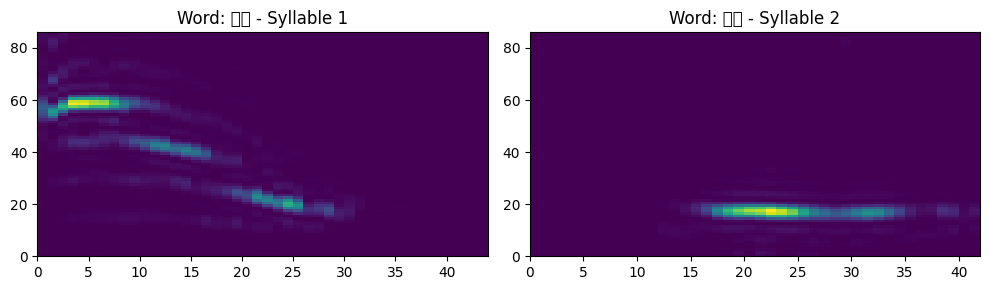

<ipython-input-17-62cac5413473>:19: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-62cac5413473>:19: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


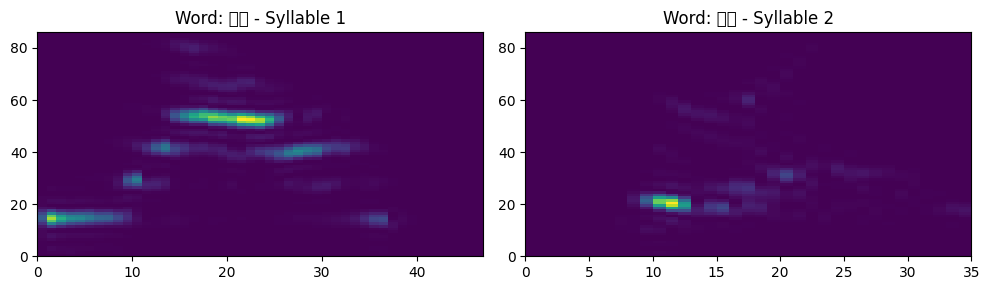

<ipython-input-17-62cac5413473>:19: UserWarning: Glyph 39292 (\N{CJK UNIFIED IDEOGRAPH-997C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-62cac5413473>:19: UserWarning: Glyph 24178 (\N{CJK UNIFIED IDEOGRAPH-5E72}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39292 (\N{CJK UNIFIED IDEOGRAPH-997C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24178 (\N{CJK UNIFIED IDEOGRAPH-5E72}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


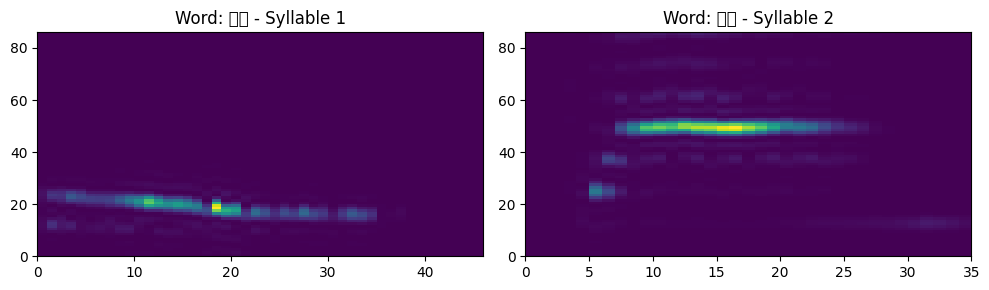

<ipython-input-17-62cac5413473>:19: UserWarning: Glyph 26448 (\N{CJK UNIFIED IDEOGRAPH-6750}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-62cac5413473>:19: UserWarning: Glyph 26009 (\N{CJK UNIFIED IDEOGRAPH-6599}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26448 (\N{CJK UNIFIED IDEOGRAPH-6750}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26009 (\N{CJK UNIFIED IDEOGRAPH-6599}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


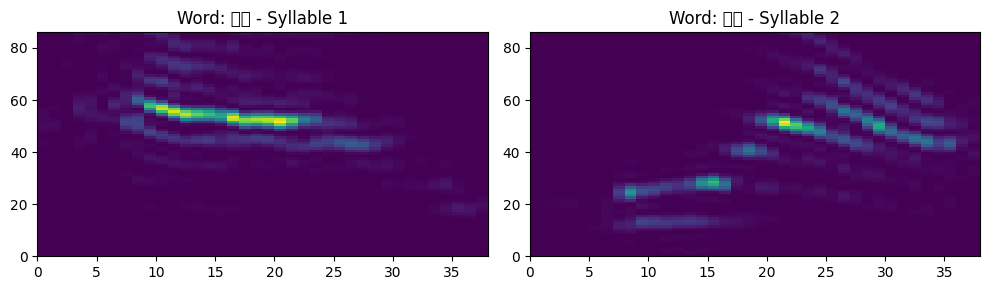

<ipython-input-17-62cac5413473>:19: UserWarning: Glyph 31383 (\N{CJK UNIFIED IDEOGRAPH-7A97}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-62cac5413473>:19: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31383 (\N{CJK UNIFIED IDEOGRAPH-7A97}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


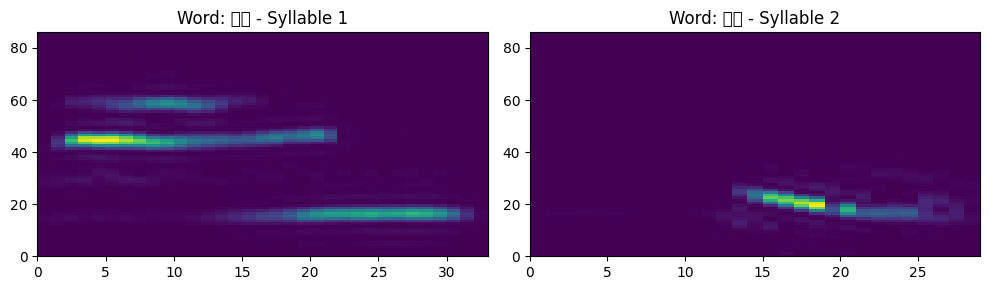

In [ ]:
# Берем первые 5 записей для примера и строим гистограммы
for i in range(0,5):
    hanzi = df['Word'].iloc[i]
    sxx = df['Sxx'].iloc[i]
    num_parts = len(hanzi)

    if num_parts == 1:
        fig, ax = plt.subplots(figsize=(8, 3))
        ax.pcolormesh(sxx)
        ax.set_title(f"Word: {hanzi} (1 syllable)")
        plt.show()

    elif num_parts == 2:
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax[0].pcolormesh(sxx[0])
        ax[0].set_title(f"Word: {hanzi} - Syllable 1")
        ax[1].pcolormesh(sxx[1])
        ax[1].set_title(f"Word: {hanzi} - Syllable 2")
        plt.tight_layout()
        plt.show()

    elif num_parts == 3:
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
        for j in range(3):
            ax[j].pcolormesh(sxx[j])
            ax[j].set_title(f"Word: {hanzi} - Syllable {j+1}")
        plt.tight_layout()
        plt.show()

    elif num_parts == 4:
        fig, ax = plt.subplots(2, 2, figsize=(10, 6))
        ax = ax.ravel()
        for j in range(4):
            ax[j].pcolormesh(sxx[j])
            ax[j].set_title(f"Word: {hanzi} - Syllable {j+1}")
        plt.tight_layout()
        plt.show()

In [ ]:
# проверим данные на пропуски
df.isnull().sum()

,0
Audio File,0
Word,0
Pinyin,0
Meaning,0
tones,1
Sxx,0


В данных есть одно слово с нулевым тонов (без тона), поэтому присутсвует один пропуск в столбце tones, удалим эту строку из данных.

In [ ]:
df = df.dropna()

Далее построим гистограмму распределения длин последовательностей спектрограмм. Поскольку в данных есть многосложные слова, которые храняться в виде списков, а не только массивы как в случае односложных слов, пропишем дополнительную проверку.

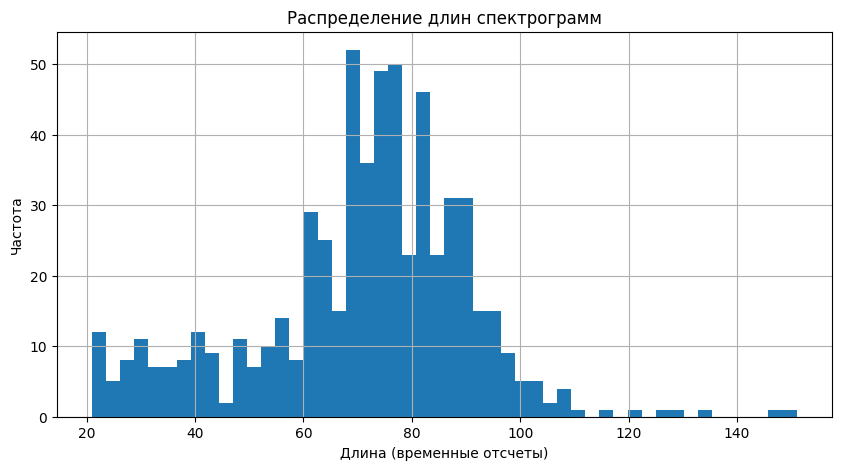

In [ ]:
# изучим распределение длин последовательностей спектрограмм

# функция должна возвращать длину спектрограммы
def get_spectrogram_length(spectrogram):
    if isinstance(spectrogram, list):
        # Для многосложных слов
        return sum(arr.shape[1] for arr in spectrogram if isinstance(arr, np.ndarray))
    elif isinstance(spectrogram, np.ndarray):
        # Для односложных слов (один массив)
        return spectrogram.shape[1]
    else:
        # На случай других форматов данных
        return 0

# Применяем функцию к каждому элементу в df.Sxx
lengths = df.Sxx.apply(get_spectrogram_length)

plt.figure(figsize=(10, 5))
lengths.hist(bins=50)
plt.title('Распределение длин спектрограмм')
plt.xlabel('Длина (временные отсчеты)')
plt.ylabel('Частота')
plt.show()

Большинство спектрограмм имеют длину от 60 до 100. Теперь необходимо выполнить нормализацию амплитуд спектрограмм. Для этого нужно поделить каждый элемент спектрограммы на максимальное значение в этой спектрограмме, чтобы привести все значения к диапазону [0, 1]. Это позволит стандартизировать данные для нейросетевых моделей и улучшить стабильность обучения модели.

In [ ]:
# функция для нормализации данных

def normalize_spectrogram(x):
   # Односложные слова
    if isinstance(x, np.ndarray):
        return x / np.max(x)
    # Многосложные слова
    elif isinstance(x, list):
        return [arr / np.max(arr) for arr in x]

df.Sxx = df.Sxx.apply(normalize_spectrogram)

В примере выполняется транспорирование данных спектрограмм – меняют оси времени и частоты местами. Я так поняла это необходимо для конкретной модели, поэтому проведем такую же манипуляцию с данными.

In [ ]:
# функция для транспорирования данных
def transpose_spectrogram(x):
    # Односложные слова
    if isinstance(x, np.ndarray):
        return x.T
    # Многосложные слова
    elif isinstance(x, list):
        return [arr.T for arr in x]  # Транспонируем каждый слог отдельно

df.Sxx = df.Sxx.apply(transpose_spectrogram)

Теперь необходимо закодировать метки классов с помощью One-Hot кодирования, преобразованные данные должны выглядеть следующим образом:

Тон 1 → [1, 0, 0, 0]

Тон 2 → [0, 1, 0, 0]

Тон 3 → [0, 0, 1, 0]

Тон 4 → [0, 0, 0, 1]

В случае многосложных слов будет создан список с закодированным значением каждого тона.

In [ ]:
# функция для кодирования таргета

def encode_tones(tones_str):
    tones = list(map(int, tones_str.split('-')))
    return [to_categorical(tone-1, num_classes=4) for tone in tones]

df['tones_onehot'] = df.tones.apply(encode_tones)

In [ ]:
df.head()

,Audio File,Word,Pinyin,Meaning,tones,Sxx,tones_onehot
id,,,,,,,
0,https://raw.githubusercontent.com/ManiyaRaskol...,爱情,àiqíng,love (romantic),4-2,"[[[9.273851e-06, 1.7316122e-05, 1.36491835e-05...","[[0.0, 0.0, 0.0, 1.0], [0.0, 1.0, 0.0, 0.0]]"
1,https://raw.githubusercontent.com/ManiyaRaskol...,标准,biāozhǔn,standard,1-3,"[[[0.0020406053, 0.0054027988, 0.007617132, 0....","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0]]"
2,https://raw.githubusercontent.com/ManiyaRaskol...,饼干,bǐnggān,biscuit,3-1,"[[[0.0010790958, 0.0020208114, 0.0016447469, 0...","[[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0]]"
3,https://raw.githubusercontent.com/ManiyaRaskol...,材料,cáiliào,"data, material",2-4,"[[[2.2056184e-09, 5.6316924e-07, 1.8245562e-06...","[[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]]"
4,https://raw.githubusercontent.com/ManiyaRaskol...,窗户,chuānghù,window,1-4,"[[[4.2335246e-06, 8.4770865e-05, 0.00021434443...","[[1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]]"


И наконец делим выборку на тренировочную и тестовую.

В отличие от примера, у меня в данных слишком много уникальных сочетаний тонов, стратификация из-за этого невозможна. Для решения проблемы можно создать отдельный датафрейм с разбиением слов по слогам и добавить id исходного слова для восстановления исходного слова.

In [ ]:
# создаём новый датафрейм для слогов
syllable_df = pd.DataFrame(columns=['spectrogram', 'tone', 'word_id', 'syllable_pos'])

for word_id, (tones, spec) in enumerate(zip(df.tones_onehot, df.Sxx)):
    for syllable_pos, (tone_part, spec_part) in enumerate(zip(tones, spec)):
        syllable_df.loc[len(syllable_df)] = {
            'spectrogram': spec_part,
            'tone': tone_part,
            'word_id': word_id,  # добавим id исходного слова из df по индексу
            'syllable_pos': syllable_pos  # еще добавим номер позиции слога в слове
        }
syllable_df

,spectrogram,tone,word_id,syllable_pos
0,"[[9.273851e-06, 1.7316122e-05, 1.36491835e-05,...","[0.0, 0.0, 0.0, 1.0]",0,0
1,"[[1.5275187e-06, 2.7196331e-06, 1.7761363e-06,...","[0.0, 1.0, 0.0, 0.0]",0,1
2,"[[0.0020406053, 0.0054027988, 0.007617132, 0.0...","[1.0, 0.0, 0.0, 0.0]",1,0
3,"[[2.8971058e-07, 5.964483e-07, 6.0065634e-07, ...","[0.0, 0.0, 1.0, 0.0]",1,1
4,"[[0.0010790958, 0.0020208114, 0.0016447469, 0....","[0.0, 0.0, 1.0, 0.0]",2,0
...,...,...,...,...
1070,"[[0.0004885269, 0.0017468097, 0.0033273527, 0....","[0.0, 0.0, 0.0, 1.0]",602,0
1071,"[[4.225423e-07, 1.5116976e-05, 3.8791866e-05, ...","[0.0, 0.0, 1.0, 0.0]",602,1
1072,"[[0.0013929863, 0.0027606674, 0.0025279182, 0....","[0.0, 1.0, 0.0, 0.0]",603,0
1073,"[[9.606417e-06, 2.0796608e-05, 2.1951004e-05, ...","[1.0, 0.0, 0.0, 0.0]",603,1


Новый датафоейм создан, теперь нужно выполнить разделение на тренировочную и тестовую выборку.

In [ ]:
# Отделяем признаки (X) и метки (y)
X = syllable_df['spectrogram'].to_list()  # или df['Sxx'].to_list(), если это список массивов
y = np.array(syllable_df['tone'].to_list())  # преобразуем в numpy-массив

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


train_df = pd.DataFrame({
    'spectrogram': X_train,  # Список массивов
    'tone': y_train.tolist()  # Список one-hot меток
})

val_df = pd.DataFrame({
    'spectrogram': X_val,
    'tone': y_val.tolist()
})

test_df = pd.DataFrame({
    'spectrogram': X_test,
    'tone': y_test.tolist()
})

In [ ]:
y_labels = np.argmax(y_train, axis=1)
unique, counts = np.unique(y_labels, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(132), np.int64(1): np.int64(164), np.int64(2): np.int64(107), np.int64(3): np.int64(242)}


In [ ]:
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print("Пример метки:", y_train[0])

Train: 645, Val: 215, Test: 215
Пример метки: [0. 0. 0. 1.]


In [ ]:
# проверим данных на дисбаланс классов
train_df.tone.value_counts()

,count
tone,
"[0.0, 0.0, 0.0, 1.0]",242
"[0.0, 1.0, 0.0, 0.0]",164
"[1.0, 0.0, 0.0, 0.0]",132
"[0.0, 0.0, 1.0, 0.0]",107


В данных действительно присутсвует дисбаланс классов – 4 тон встречается практически в 2 раза чаще остальных. Особенно редкор в данных представлен тон 3. Попробуем решить проблему с помощью взвешенной функции потерь при обучении модели.

# Обучение модели

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
BATCH_SIZE = 32
EPOCHS = 50 #как я поняла, чем меньше данных, тем больше эпох нужно
SPECTROGRAM_INP_SIZE = 86
STEPS_PER_EPOCH = len(train_df) // BATCH_SIZE

In [ ]:
def training_batch_generator(batch_size):
    """Генератор для моего маленького датасета (~600 примеров)."""
    while True:  # Бесконечный цикл для совместимости с model.fit()
        # Перемешиваем данные каждый раз
        shuffled_df = train_df.sample(frac=1.0, replace=False)

        # Разделяем на батчи
        for i in range(0, len(shuffled_df), batch_size):
            batch = shuffled_df.iloc[i:i + batch_size]
            encoder_input = batch.spectrogram.to_list()

            # Дополняем нулями до максимальной длины в батче
            max_len = max([s.shape[0] for s in encoder_input])
            encoder_input_padded = np.array([
                np.pad(s, ((0, max_len - s.shape[0]), (0, 0)))
                for s in encoder_input
            ])

            y_batch = np.array(batch.tone.to_list())

            # Веса по классам (tone): используем np.argmax для получения индекса класса
            sample_weights = np.array([
                class_weights[int(np.argmax(onehot))] for onehot in y_batch
            ])

            yield encoder_input_padded, y_batch, sample_weights

In [ ]:
#генератор для валидации
def val_batch_generator(batch_size):
    """Генератор для валидации."""
    while True:
        shuffled_df = val_df.sample(frac=1.0, replace=False)
        for i in range(0, len(shuffled_df), batch_size):
            batch = shuffled_df.iloc[i:i + batch_size]
            encoder_input = batch.spectrogram.to_list()
            max_len = max([s.shape[0] for s in encoder_input])
            encoder_input_padded = np.array([
                np.pad(s, ((0, max_len - s.shape[0]), (0, 0)))
                for s in encoder_input
            ])
            yield encoder_input_padded, np.array(batch.tone.to_list())


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Мониторим потерю на валидации
    patience=5,         # Ждем 5 эпох без улучшений
    restore_best_weights=True  # Возвращаем лучшие веса
)

In [ ]:
#создаем генератор для оценки качества обучения на каждой эпохе

class ValidationCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):

      encoder_input = val_df.spectrogram.to_list()
      max_input_sequence_length = max([sequence.shape[0] for sequence in encoder_input])
      encoder_input = [np.pad(sequence, ((0, max_input_sequence_length - sequence.shape[0]), (0, 0))) for sequence in encoder_input]

      target = np.array(val_df.tone.to_list())
      pred = self.model.predict(np.array(encoder_input))

      cce = CategoricalCrossentropy()
      loss = cce(tf.convert_to_tensor(target), tf.convert_to_tensor(pred)).numpy()
      #loss = tf.reduce_mean(tf.categorical_crossentropy(tf.convert_to_tensor(target), tf.convert_to_tensor(pred))).numpy()

      acc = Accuracy()
      acc.update_state(np.argmax(target, axis=1), np.argmax(pred, axis=1))

      print("validation loss: {0:.4f}, validation acc: {1:.4f}".format(loss, acc.result().numpy()))

      if 'val_loss' in self.model.history.history.keys():
          self.model.history.history["val_loss"].append(loss)
      else:
          self.model.history.history["val_loss"]= [loss]

      if 'val_acc' in self.model.history.history.keys():
          self.model.history.history["val_acc"].append(acc.result().numpy())
      else:
          self.model.history.history["val_acc"]= [acc.result().numpy()]

Я если често слабо понимаю, что происходит в двух верхних ячейках. Я так поняла это что-то с архитектурой модели. Из-за того, что я слаба поняла, эти части я вставила практически без изменений.


Далее в примере используют предварительно обученный кодировщик, но какбы мне его загрузить...

**Проблема:**  в примере используют предобученный на китайском языке LSTM-кодировщик для первой части архитектуры, но у меня нет к нему доступа. Из альтернативных решений я могу заменить энкодер альтернативной архитектурой:

from tensorflow.keras.layers import LSTM

Или полность упростить архитектуру модели (убрать часть, где он был нужен)

In [ ]:
""" ВАРИАНТ 1 """

from tensorflow.keras.layers import LSTM

# Заменяем предобученный энкодер на новый LSTM-слой
encoder_inputs = Input(shape=(None, SPECTROGRAM_INP_SIZE))
encoder_outputs = LSTM(64, return_sequences=False)(encoder_inputs)  # 64 — размер скрытого состояния

# Остальная часть архитектуры без изменений
dropout_output = Dropout(0.5)(encoder_outputs)
outputs = Dense(4, activation='softmax')(dropout_output)

model = Model(encoder_inputs, outputs)
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 86)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        38,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,916 (152.02 KB)

 Trainable params: 38,916 (152.02 KB)

 Non-trainable params: 0 (0.00 B)

Попробовать увеличить dropout

In [ ]:
from sklearn.utils import class_weight

y_train_labels = np.argmax(y_train, axis=1)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(1.2215909090909092), 1: np.float64(0.9832317073170732), 2: np.float64(1.5070093457943925), 3: np.float64(0.6663223140495868)}


In [ ]:
history = model.fit(
    training_batch_generator(BATCH_SIZE),
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_batch_generator(BATCH_SIZE),
    validation_steps=STEPS_PER_EPOCH,
    callbacks=[ValidationCallback(), early_stopping]
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
validation loss: 1.0728, validation acc: 0.5116
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.6114 - loss: 0.9853 - val_accuracy: 0.5370 - val_loss: 1.0666
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
validation loss: 1.0699, validation acc: 0.5256
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.6114 - loss: 0.9766 - val_accuracy: 0.5434 - val_loss: 1.0671
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
validation loss: 1.0642, validation acc: 0.5116
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5926 - loss: 0.9741 - val_accuracy: 0.5449 - val_loss: 1.0292
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
validation loss: 1.0465, validation acc: 0.5349
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6069 - loss: 0.9777 - val_accuracy: 0.5400 - val_loss: 1.0239
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
validation loss: 1.0255, validation acc: 0.5488
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accurac

[]

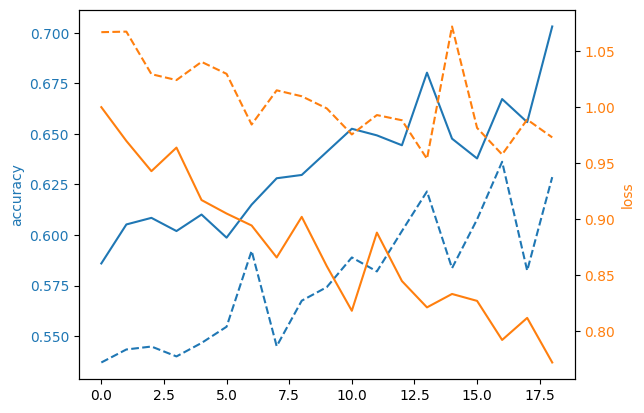

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(history.history['accuracy'], color='C0')
ax1.plot(history.history['val_accuracy'], color='C0', linestyle='--')
ax2 = ax1.twinx()
ax2.plot(history.history['loss'], color='C1')
ax2.plot(history.history['val_loss'], color='C1', linestyle='--')
ax1.set_ylabel('accuracy', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax2.set_ylabel('loss', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
plt.plot()




Посмотрим на спктрограммы пердсказанных тонов в сравнении с истинными метками.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


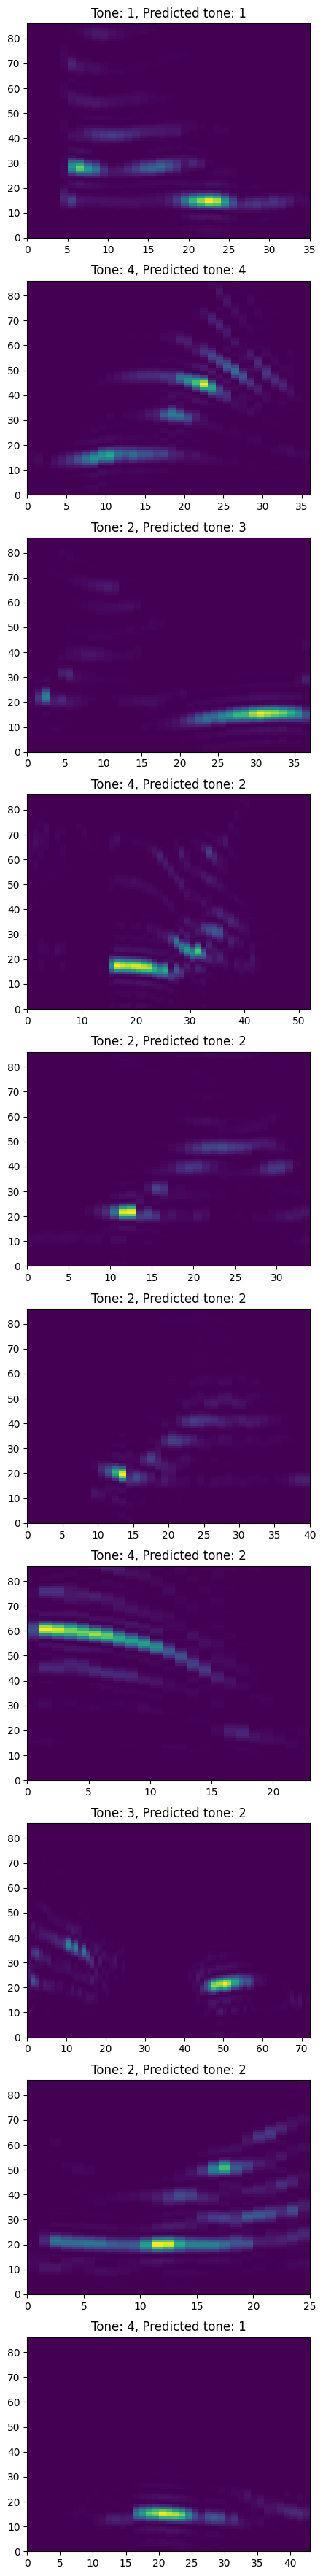

In [ ]:
fig, ax = plt.subplots(10, 1, figsize=(5, 45))
for i, index in enumerate(random.sample(range(syllable_df.shape[0]), 10)):
    example = syllable_df.loc[index]
    ax[i].pcolormesh(example.spectrogram.T)
    ax[i].set_title("Tone: {}, Predicted tone: {}".format(np.argmax(example.tone)+1,
                                                                np.argmax(model.predict(np.expand_dims(example.spectrogram, 0)))+1))
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


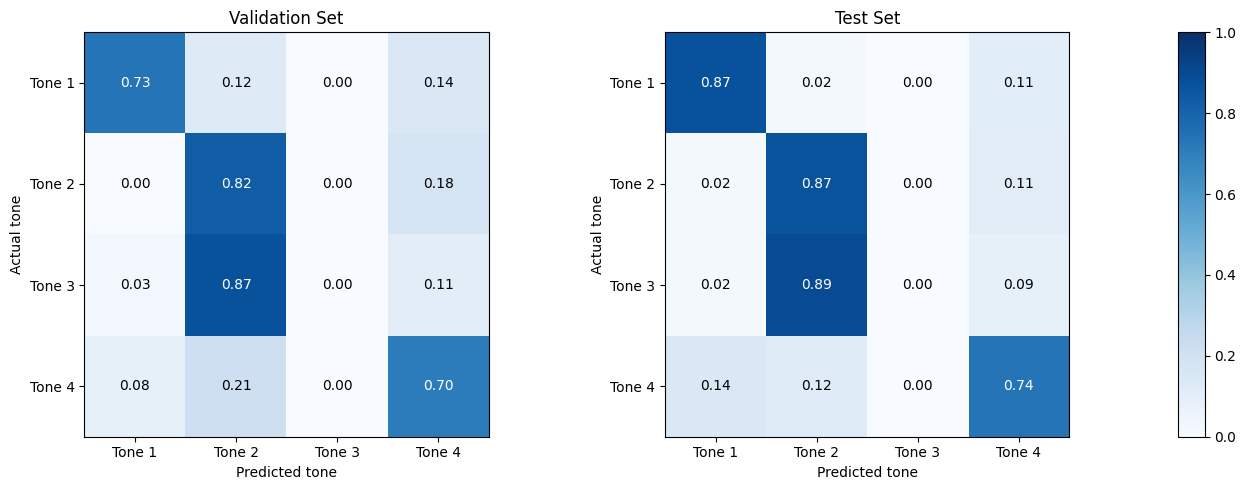

In [ ]:
#строим матрицу ошибок
fig = plt.figure(figsize=(13, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cax = fig.add_subplot(gs[2])

for i, (encoder_input, target, ax_curr, title) in enumerate([
    (val_df.spectrogram.to_list(), np.array(val_df.tone.to_list()), ax0, "Validation Set"),
    (test_df.spectrogram.to_list(), np.array(test_df.tone.to_list()), ax1, "Test Set")
]):
    max_len = max([seq.shape[0] for seq in encoder_input])
    encoder_input = [np.pad(seq, ((0, max_len - seq.shape[0]), (0, 0))) for seq in encoder_input]
    encoder_input = np.array(encoder_input)
    pred = model.predict(encoder_input)

    num_classes = 4
    cm = tf.math.confusion_matrix(np.argmax(target, axis=1),
                                  np.argmax(pred, axis=1),
                                  num_classes=num_classes).numpy()
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax_curr.imshow(cm, cmap=plt.cm.Blues, vmin=0, vmax=1)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for m in range(cm.shape[0]):
        for n in range(cm.shape[1]):
            ax_curr.text(n, m, format(cm[m, n], fmt),
                         ha="center", va="center",
                         color="white" if cm[m, n] > thresh else "black")

    ax_curr.set_xlabel("Predicted tone")
    ax_curr.set_ylabel("Actual tone")
    ax_curr.set_xticks(range(num_classes))
    ax_curr.set_yticks(range(num_classes))
    ax_curr.set_xticklabels([f"Tone {i+1}" for i in range(num_classes)])
    ax_curr.set_yticklabels([f"Tone {i+1}" for i in range(num_classes)])
    ax_curr.set_title(title)

# Отдельная шкала
fig.colorbar(im, cax=cax)
plt.tight_layout()
plt.show()


In [ ]:
# Посчитаем значение метрик на валидационной выборки

encoder_input = test_df.spectrogram.to_list()
target = np.array(test_df.tone.to_list())

# Выравнивание последовательностей по длине
max_len = max([seq.shape[0] for seq in encoder_input])
encoder_input = [np.pad(seq, ((0, max_len-seq.shape[0]), (0, 0))) for seq in encoder_input]
encoder_input = np.array(encoder_input)

pred = model.predict(encoder_input)

# Преобразование one-hot в метки классов
y_true = np.argmax(target, axis=1)
y_pred = np.argmax(pred, axis=1)

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Значение метрик на тестовой выборке:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Значение метрик на тестовой выборке:
Precision: 0.4970
Recall:    0.6190
F1-Score:  0.5381


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
